In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 38.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import os
import koreanize_matplotlib
from IPython.display import Image
import requests
from io import BytesIO
from IPython.display import display, HTML

In [ ]:
import os
import json
import pandas as pd

# 1) 어노테이션 JSON이 들어있는 최상위 디렉터리
annotations_dir = '/content/drive/Othercomputers/내 MacBook Air/Documents/ai_project/beginner_project/ai02-level1-project/train/train_annotations'

# 2) 결과 레코드를 담을 리스트
records = []

# 3) 모든 서브디렉터리의 JSON 파일 순회
for root, dirs, files in os.walk(annotations_dir):
    for fname in files:
        if not fname.lower().endswith('.json'):
            continue

        path = os.path.join(root, fname)
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # 4) images, categories 블록을 ID → dict 매핑
        images_map = {img['id']: img for img in data.get('images', [])}
        cats_map   = {c['id']: c for c in data.get('categories', [])}
        file_type  = data.get('type', None)

        # 5) annotations 리스트를 순회하며 레코드 생성
        for ann in data.get('annotations', []):
            rec = {}

            # (a) 이미지 정보 앞에 img_ 접두사
            img = images_map.get(ann['image_id'], {})
            for k, v in img.items():
                rec[f"img_{k}"] = v

            # (b) annotation 정보 (area, bbox, id, iscrowd, …)
            for k, v in ann.items():
                rec[k] = v

            # (c) 카테고리 정보 합치기
            cat = cats_map.get(ann['category_id'], {})
            rec['category_super'] = cat.get('supercategory')
            rec['category_name']  = cat.get('name')

            # (d) file type
            rec['file_type'] = file_type

            records.append(rec)

# 6) DataFrame 생성 및 CSV 저장
df = pd.DataFrame.from_records(records)
df.to_csv('/content/drive/Othercomputers/내 MacBook Air/Documents/ai_project/beginner_project/data/annotations.csv', index=False)

# 7) 결과 확인 (필요시)
print(df.shape)
print(df.columns.tolist())
print(df.head())


(4526, 61)
['img_file_name', 'img_width', 'img_height', 'img_imgfile', 'img_drug_N', 'img_drug_S', 'img_back_color', 'img_drug_dir', 'img_light_color', 'img_camera_la', 'img_camera_lo', 'img_size', 'img_dl_idx', 'img_dl_mapping_code', 'img_dl_name', 'img_dl_name_en', 'img_img_key', 'img_dl_material', 'img_dl_material_en', 'img_dl_custom_shape', 'img_dl_company', 'img_dl_company_en', 'img_di_company_mf', 'img_di_company_mf_en', 'img_item_seq', 'img_di_item_permit_date', 'img_di_class_no', 'img_di_etc_otc_code', 'img_di_edi_code', 'img_chart', 'img_drug_shape', 'img_thick', 'img_leng_long', 'img_leng_short', 'img_print_front', 'img_print_back', 'img_color_class1', 'img_color_class2', 'img_line_front', 'img_line_back', 'img_img_regist_ts', 'img_form_code_name', 'img_mark_code_front_anal', 'img_mark_code_back_anal', 'img_mark_code_front_img', 'img_mark_code_back_img', 'img_mark_code_front', 'img_mark_code_back', 'img_change_date', 'img_id', 'area', 'iscrowd', 'bbox', 'category_id', 'ignore

In [14]:
df = pd.read_csv('/content/drive/Othercomputers/내 MacBook Air/Documents/ai_project/beginner_project/data/annotations.csv')
print(df.head())

                                       img_file_name  img_width  img_height  \
0  K-001900-010224-016551-031705_0_2_0_2_90_000_2...        976        1280   
1  K-001900-010224-016551-031705_0_2_0_2_75_000_2...        976        1280   
2  K-001900-010224-016551-031705_0_2_0_2_70_000_2...        976        1280   
3  K-001900-010224-016551-031705_0_2_0_2_90_000_2...        976        1280   
4  K-001900-010224-016551-031705_0_2_0_2_75_000_2...        976        1280   

                                         img_imgfile img_drug_N img_drug_S  \
0  K-001900-010224-016551-031705_0_2_0_2_90_000_2...   K-001900       정상알약   
1  K-001900-010224-016551-031705_0_2_0_2_75_000_2...   K-001900       정상알약   
2  K-001900-010224-016551-031705_0_2_0_2_70_000_2...   K-001900       정상알약   
3  K-001900-010224-016551-031705_0_2_0_2_90_000_2...   K-016551       정상알약   
4  K-001900-010224-016551-031705_0_2_0_2_75_000_2...   K-016551       정상알약   

  img_back_color img_drug_dir img_light_color  img_camer

In [ ]:
# width, height의 같은 값들의 개수
df.groupby(['img_width','img_height']).size()

img_width  img_height
976        1280          4526
dtype: int64

In [ ]:
# df 결측값 143개
df.isnull().sum()

img_file_name     0
img_width         0
img_height        0
img_imgfile       0
img_drug_N        0
                 ..
id                0
image_id          0
category_super    0
category_name     0
file_type         0
Length: 61, dtype: int64

## 알약 이미지 확인

In [23]:
img_name = df[['img_img_key', 'img_dl_name']]
link_name_obj = {}

# img_dl_name이 key로 오고 img_img_key가 value 온다. 중복되지 않게한다.
for i in range(len(img_name)):
  if img_name.iloc[i, 1] in link_name_obj:
    continue
  link_name_obj[img_name.iloc[i, 1]] = img_name.iloc[i, 0]

for key, value in link_name_obj.items():
  print(key, value)

print(len(link_name_obj))

보령부스파정 5mg http://connectdi.com/design/img/drug/1Mxwka5v0lL.jpg
동아가바펜틴정 800mg http://connectdi.com/design/img/drug/152484364307100015.jpg
낙소졸정 500/20mg http://connectdi.com/design/img/drug/154597931877100021.jpg
신바로정 http://connectdi.com/design/img/drug/148431162903300172.jpg
가바토파정 100mg nan
란스톤엘에프디티정 30mg http://connectdi.com/design/img/drug/1MwjLoFp4UL.jpg
펠루비정(펠루비프로펜) http://connectdi.com/design/img/drug/147427824984200145.jpg
울트라셋이알서방정 http://connectdi.com/design/img/drug/1NOwp2F6It9.jpg
비모보정 500/20mg http://connectdi.com/design/img/drug/154661642891500031.jpg
레일라정 http://connectdi.com/design/img/drug/152285645249800077.jpg
스토가정 10mg http://connectdi.com/design/img/drug/1MrFeLzYHjR.jpg
라비에트정 20mg http://connectdi.com/design/img/drug/147428282917500179.jpg
놀텍정 10mg http://connectdi.com/design/img/drug/151706776344700001.jpg
에스원엠프정 20mg http://connectdi.com/design/img/drug/1MYTX0L3Ktb.jpg
케이캡정 50mg http://connectdi.com/design/img/drug/1NdI1kwNhiL.jpg
알드린정 http://connectdi.com/design/

In [22]:


for name, url in link_name_obj.items():
    # URL이 유효한 문자열인지 판단
    if isinstance(url, str) and url.startswith("http"):
        try:
            response = requests.get(url, timeout=5)
            response.raise_for_status()  # 200이 아니면 예외 발생
            img = Image.open(BytesIO(response.content))

            # Colab에서는 display(img)만 해도 PIL 이미지를 렌더링해줍니다.
            print(f"----- {name} -----")
            display(img)

        except Exception as e:
            print(f"{name}: 이미지 로드 실패 ({e})")
    else:
        print(f"{name}: (이미지 없음)")

Output hidden; open in https://colab.research.google.com to view.

## 보령 부스파정 5mg 확인

In [24]:
test = df[df['img_dl_name'] == '보령부스파정 5mg']
print(test)

                                         img_file_name  img_width  img_height  \
0    K-001900-010224-016551-031705_0_2_0_2_90_000_2...        976        1280   
1    K-001900-010224-016551-031705_0_2_0_2_75_000_2...        976        1280   
2    K-001900-010224-016551-031705_0_2_0_2_70_000_2...        976        1280   
8    K-001900-010224-016551-033009_0_2_0_2_90_000_2...        976        1280   
9    K-001900-010224-016551-033009_0_2_0_2_75_000_2...        976        1280   
..                                                 ...        ...         ...   
692  K-001900-016551-033009-033208_0_2_0_2_75_000_2...        976        1280   
693  K-001900-016551-033009-033208_0_2_0_2_70_000_2...        976        1280   
700  K-001900-016551-033009-044199_0_2_0_2_75_000_2...        976        1280   
701  K-001900-016551-033009-044199_0_2_0_2_70_000_2...        976        1280   
702  K-001900-016551-033009-044199_0_2_0_2_90_000_2...        976        1280   

                           

## 알약상태(drug_S)
"정상알약"만 존재함

In [ ]:
# 알약 상태 확인
df['img_drug_S'].describe()

count     4526
unique       1
top       정상알약
freq      4526
Name: img_drug_S, dtype: object

## 촬영배경(back_color)
"연회색 배경"만 존재한다.

In [ ]:
# 촬영 배경
df['img_back_color'].describe()

count       4526
unique         1
top       연회색 배경
freq        4526
Name: img_back_color, dtype: object

## 알약방향(drug_dir)
앞면은 4513개, 뒷면은 13개로 클래스 불균형이 존재한다.

In [ ]:
df['img_drug_dir'].describe()

count     4526
unique       2
top         앞면
freq      4513
Name: img_drug_dir, dtype: object

In [ ]:
df['img_drug_dir'].value_counts()

img_drug_dir
앞면    4513
뒷면      13
Name: count, dtype: int64

## 촬영조명(light_color)
"주백색"만 존재한다.

In [ ]:
df['img_light_color'].describe()

count     4526
unique       1
top        주백색
freq      4526
Name: img_light_color, dtype: object

## 카메라위도(camera_la)
70, 75, 90도 3개가 각각 균형있게 존재한다.

In [ ]:
df['img_camera_la'].describe()

count    4526.000000
mean       78.336279
std         8.490777
min        70.000000
25%        70.000000
50%        75.000000
75%        90.000000
max        90.000000
Name: img_camera_la, dtype: float64

In [ ]:
df['img_camera_la'].isnull().sum()

np.int64(0)

In [ ]:
df['img_camera_la'].value_counts()

img_camera_la
75    1518
90    1507
70    1501
Name: count, dtype: int64

## 카메라경도(camera_lo)
모든 값이 0이다.

In [ ]:
df['img_camera_lo'].describe()

count    4526.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: img_camera_lo, dtype: float64

## 알약 식별자(dl_idx)
사진에 나오는 알약들 클래스가 불균형하다.

In [ ]:
df['img_dl_idx'].describe()

count     4526
unique      73
top       3482
freq       514
Name: img_dl_idx, dtype: object

In [ ]:
df['img_dl_idx'].isnull().sum()

np.int64(0)

In [ ]:
df['img_dl_idx'].value_counts()

img_dl_idx
3482     514
3350     240
1899     180
2482     172
16547    143
        ... 
27992     11
23202     10
12419      9
29870      9
33877      7
Name: count, Length: 73, dtype: int64

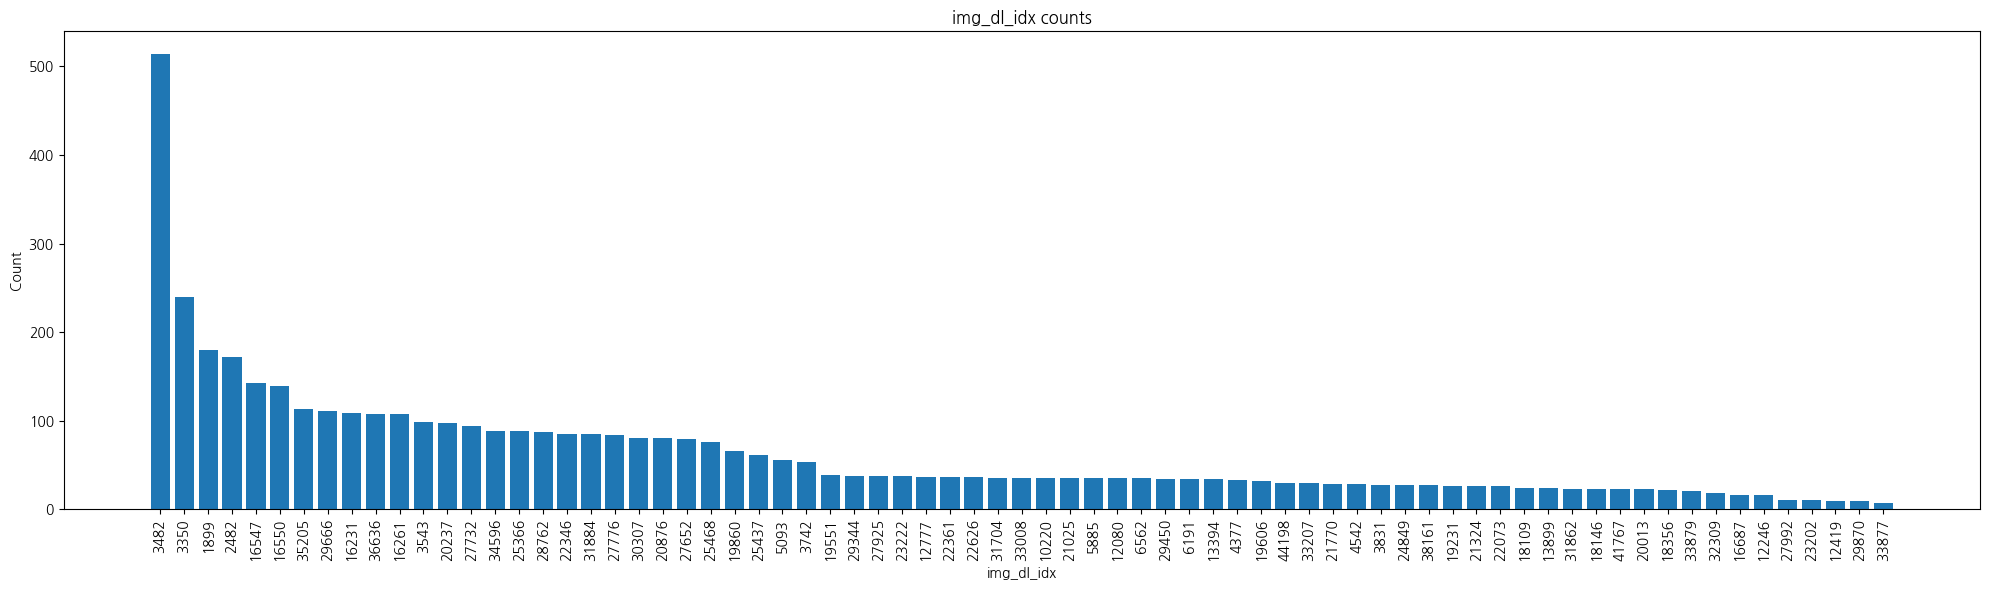

In [ ]:
# 데이터 로드

# img_dl_idx별 개수 계산
vc = df['img_dl_idx'].value_counts()

# 전체 고유값 시각화
plt.figure(figsize=(20, 6))
plt.bar(vc.index.astype(str), vc.values)
plt.xticks(rotation=90)
plt.xlabel('img_dl_idx')
plt.ylabel('Count')
plt.title('img_dl_idx counts')
plt.tight_layout()
plt.show()


In [ ]:
print(vc)

img_dl_idx
3482     514
3350     240
1899     180
2482     172
16547    143
        ... 
27992     11
23202     10
12419      9
29870      9
33877      7
Name: count, Length: 73, dtype: int64


## 제품코드(dl_mapping_code)
알약이 제품으로 판매되므로 제품의 고유 코드를 의미

알약이 이미지에 나타난 횟수가 dl_idx와 같다.

In [ ]:
df['img_dl_mapping_code'].describe()

count         4526
unique          73
top       K-003483
freq           514
Name: img_dl_mapping_code, dtype: object

In [ ]:
df['img_dl_mapping_code'].value_counts()

img_dl_mapping_code
K-003483    514
K-003351    240
K-001900    180
K-002483    172
K-016548    143
           ... 
K-027993     11
K-023203     10
K-012420      9
K-029871      9
K-033878      7
Name: count, Length: 73, dtype: int64

## 제품명(dl_name)
알약 제품 출시했을때, 제품의 이름

In [ ]:
df['img_dl_name'].describe()

count                   4526
unique                    73
top       기넥신에프정(은행엽엑스)(수출용)
freq                     514
Name: img_dl_name, dtype: object

In [ ]:
df['img_dl_name'].value_counts()

img_dl_name
기넥신에프정(은행엽엑스)(수출용)    514
일양하이트린정 2mg           240
보령부스파정 5mg            180
뮤테란캡슐 100mg           172
가바토파정 100mg           143
                     ... 
졸로푸트정 100mg            11
쿠에타핀정 25mg             10
자이프렉사정 2.5mg            9
렉사프로정 15mg              9
브린텔릭스정 20mg             7
Name: count, Length: 73, dtype: int64

In [ ]:
df['img_dl_name'].isnull().sum()

np.int64(0)

## 영어 제품명(dl_name_en)

4526개의 샘플이 있는데 4508개이니 18개의 결측치가 존재한다.

총 73개 클래스중에 72개 클래스가 존재한다. 그중 1개의 클래스의 값이 비어있다.

In [ ]:
df['img_dl_name_en'].describe()

count               4508
unique                72
top       Ginexin-F Tab.
freq                 514
Name: img_dl_name_en, dtype: object

In [ ]:
df['img_dl_name_en'].value_counts()

img_dl_name_en
Ginexin-F Tab.             514
Hytrin Tab. 2mg Ilyang     240
Buspar Tab. 5mg Boryung    180
Muteran Cap. 100mg         172
Gabatopa Tab. 100mg        143
                          ... 
Zoloft Tab. 100mg           11
Quetapin Tab. 25mg          10
Zyprexa Tab. 2.5mg           9
Lexapro Tab. 15mg            9
Brintellix Tab. 20mg         7
Name: count, Length: 73, dtype: int64

In [ ]:
df['img_dl_name_en'].isnull().sum()

np.int64(0)

## 성분명(dl_material)

16개의 클래스중 몇개 끼리 뭉쳐서 동일한 성분을 가지고 있다.

성분명이 없는 결측치 값이 있다. 그 결측값인 클래스가 3개가 존재한다.

In [ ]:
df['img_dl_material'].describe()

count        4526
unique         63
top       은행엽건조엑스
freq          514
Name: img_dl_material, dtype: object

In [ ]:
df['img_dl_name_en'].value_counts()

img_dl_name_en
Ginexin-F Tab.             514
Hytrin Tab. 2mg Ilyang     240
Buspar Tab. 5mg Boryung    180
Muteran Cap. 100mg         172
Gabatopa Tab. 100mg        143
                          ... 
Zoloft Tab. 100mg           11
Quetapin Tab. 25mg          10
Zyprexa Tab. 2.5mg           9
Lexapro Tab. 15mg            9
Brintellix Tab. 20mg         7
Name: count, Length: 73, dtype: int64

In [ ]:
# 1) 재료별 제품명 개수 집계 → 2개 이상인 재료만 추출
material_name_counts = df.groupby('img_dl_material')['img_dl_name'].nunique()
dup_materials = material_name_counts[material_name_counts > 1].index

# 2) 해당 재료들에 대해 제품명 목록 조회
same_material_diff_names = (
    df[df['img_dl_material'].isin(dup_materials)]
      .groupby('img_dl_material')['img_dl_name']
      .unique()
      .reset_index()
      .rename(columns={'img_dl_name':'제품명_목록'})
)

pd.set_option('display.max_colwidth', None)
same_material_diff_names


,img_dl_material,제품명_목록
0,,"[트루비타정 60mg/병, 다보타민큐정 10mg/병, 메가파워정 90mg/병]"
1,로수바스타틴칼슘|에제티미브,"[로수젯정10/5밀리그램, 로수바미브정 10/20mg]"
2,아세트아미노펜,"[써스펜8시간이알서방정 650mg, 타이레놀이알서방정(아세트아미노펜)(수출용), 타이레놀정500mg]"
3,콜린알포세레이트,"[글리틴정(콜린알포세레이트), 콜리네이트연질캡슐 400mg, 종근당글리아티린연질캡슐(콜린알포세레이트) , 글리아타민연질캡슐]"
4,쿠에티아핀푸마르산염,"[쎄로켈정 100mg, 쿠에타핀정 25mg]"
5,프레가발린,"[카발린캡슐 25mg, 리리카캡슐 150mg]"


## 영어 성분명(dl_material_en)

In [ ]:
df['img_dl_material_en'].describe()

count                 4526
unique                  66
top       Ginkgo Leaf Ext.
freq                   514
Name: img_dl_material_en, dtype: object

In [ ]:
df['img_dl_material_en'].value_counts()

img_dl_material_en
Ginkgo Leaf Ext.                                          514
Terazosin Hydrochloride Hydrate                           240
Buspirone Hydrochloride                                   180
Metformin Hydrochloride| Sitagliptin Phosphate Hydrate    173
Acetylcysteine                                            172
                                                         ... 
Omega-3-Acid Ethyl Esters90                                16
Sertraline Hydrochloride                                   11
Olaparib                                                    9
Escitalopram Oxalate                                        9
Vortioxetine Hydrobromide                                   7
Name: count, Length: 66, dtype: int64

In [ ]:
df['img_dl_material_en']

0                         Fimasartan Potassium Trihydrate
1                         Fimasartan Potassium Trihydrate
2                         Fimasartan Potassium Trihydrate
3       Metformin Hydrochloride| Sitagliptin Phosphate...
4       Metformin Hydrochloride| Sitagliptin Phosphate...
                              ...                        
4521                      Terazosin Hydrochloride Hydrate
4522                      Terazosin Hydrochloride Hydrate
4523                      Terazosin Hydrochloride Hydrate
4524                                Clopidogrel Bisulfate
4525                                Clopidogrel Bisulfate
Name: img_dl_material_en, Length: 4526, dtype: object

## 알약 모양(drug_shape)
143개의 null 값이 존재한다.(결측치)

육각형, 팔각형의 데이터 불균형이 나타난다.

In [ ]:
df['img_drug_shape'].describe()

count     4383
unique       6
top         원형
freq      1491
Name: img_drug_shape, dtype: object

In [ ]:
drug_shape_value_counts = df['img_drug_shape'].value_counts()

In [ ]:
df['img_drug_shape'].isnull().sum()

np.int64(143)

<Axes: xlabel='img_drug_shape', ylabel='count'>

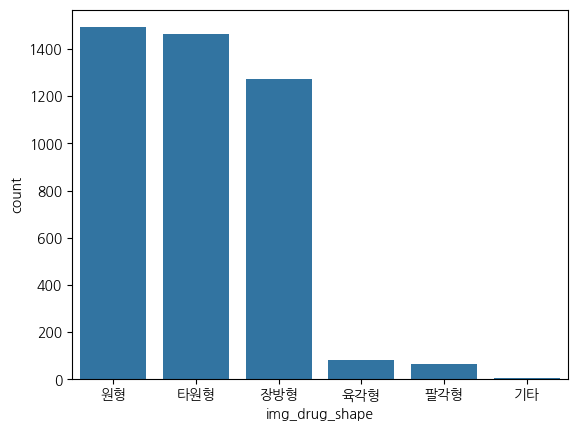

In [ ]:
sns.barplot(data=drug_shape_value_counts)